## Train Modified Model -- Development of a Transaction Categorization Model with Increased Importance for Clothing

This notebook aims to recreate the model to categorize transactions, with a difference: clothing category should be prioritized.

### Tasks:
 - [ ] Load training dataset.
 - [ ] Create k folds for experiments.
 - [ ] Generate feature vector.
 - [ ] Train model.
     - [ ] Adjust weights;
     - [ ] Increase `clothing` category weight;
     - [ ] Compute metrics based on folds;
     - [ ] Train final model;
 - [ ] Submit model, parameters and metrics do MLflow.

## Libraries and Configurations

In [1]:
import copy
from operator import itemgetter

import pandas as pd
from lightgbm.sklearn import LGBMClassifier

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

from application.code.core.configurations import configs
from application.code.adapters.storage import read_dataset
from application.code.core.dataset_split_service import generate_folds, describe_datasets
from application.code.core.feature_engineering import engineer_features, standardize_labels
from application.code.core.model_training_service import train_model
from application.code.core.model_training import (clean_data,
                                                  vectorize_folds,
                                                  compute_weights,
                                                  adjust_weights,
                                                  generate_encoders,
                                                  vectorize_dataset,
                                                  combine_feature_columns)
from application.code.core.model_evaluation import (compute_multiclass_classification_metrics,
                                                    generate_classification_report,
                                                    generate_feature_importance_report,
                                                    generate_confusion_matrix_report,
                                                    generate_labels_support,
                                                    plot_folds_metrics)
from application.code.adapters.mlflow_adapter import (log_dataframe_artifact, 
                                                      get_mlflow_artifact_content,
                                                      log_model,
                                                      register_model,
                                                      publish_model)
from application.code.core.financial_classification_model import FinancialClassificationModel

sns.set_style("whitegrid")

## Constants

In [2]:
BASE_MODEL_PARAMS = {
    'objective': 'multiclass', 
    'metric': 'multi_error',
    'verbosity': -1, 
    'n_estimators': 500,
    'random_state': configs.model_training.model_seed,
    'deterministic': True
}

TARGET_COLUMN = 'grupo_estabelecimento'

CATEGORICAL_COLUMNS = ['cidade', 'estado', 'sexo', 
                       'cidade_estabelecimento','pais_estabelecimento']

HIGH_CARDINALITY_CATEGORICAL_COLUMNS = [
    'cidade', 'estado', 
    'cidade_estabelecimento', 'pais_estabelecimento', 'estado_estabelecimento',
]

BINARY_COLUMNS = ['sexo',  'dia_util',
                  'cidade_diferente', 'estado_diferente', 'pais_diferente',]

NUMERIC_COLUMNS = ['idade',
                   'limite_total', 'limite_disp', 'valor', 
                   'dia_semana', 'dia_mes', 'mes',
                   'valor_relativo_total', 'valor_relativo_disponivel',
                  ]

COLUMNS_SELECTION  = combine_feature_columns(HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
                                             BINARY_COLUMNS,
                                             NUMERIC_COLUMNS)

EXPERIMENT_RUN_NAME = 'Base Model'

## MLflow Settings

In [3]:
mlflow.set_tracking_uri(configs.mlflow.uri)
mlflow.set_experiment(configs.mlflow.experiment_name);

## Load Dataset

The `training` dataset is loaded to create the model perform experiments.

In [4]:
df = read_dataset(base_path=configs.datasets.base_path, stage='raw', file_name='train')

display(HTML('<h4>Dataset</h4>'))
print(f'Records: {len(df)}')

Records: 3944


Split `training` set into a set of `training` and `validation` folds.

In [5]:
folds = generate_folds(df,
                       n_folds=configs.model_training.folds,
                       min_validation_size=configs.model_training.min_validation_size,
                       seed=configs.model_training.data_seed)

## Dataset Preprocessing and Feature Vectorization

Vectorization of each fold.

In [6]:
vectorized_folds = vectorize_folds(folds,
                                   columns_selection=COLUMNS_SELECTION,
                                   categorical_columns=CATEGORICAL_COLUMNS,
                                   high_cardinality_categorical_columns=HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
                                   binary_columns=BINARY_COLUMNS,
                                   target_column=TARGET_COLUMN,
                                  )

## Model Training on Folds

### Training and Evaluation on Folds

In [7]:
%%time

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

iterations_tracking = []
resources = []

weights_adjustments = {'vestuário': 2}

for ix, ((train_X, train_y), (valid_X, valid_y), labels) in enumerate(vectorized_folds):

    class_weights = compute_weights(train_y)
    class_weights = adjust_weights(class_weights, labels, weights_adjustments)

    model_params.update({'class_weight': class_weights,
                         'num_class': len(set(train_y))})

    model = LGBMClassifier(**model_params)
    model.fit(train_X, train_y)

    preds = model.predict(valid_X)
    eval_metrics = compute_multiclass_classification_metrics(valid_y, 
                                                             preds)

    iteration_tracking = {**{'Fold': ix,
                             'training_size': train_X.shape[0],
                             'validation_size': valid_X.shape[0],},
                          **eval_metrics}
    iterations_tracking.append(iteration_tracking)    

    resources.append({'model': model,
                      'preds': preds,
                      'y': valid_y,
                      'labels': labels
                     })

CPU times: user 6min 8s, sys: 2.51 s, total: 6min 10s
Wall time: 53.4 s


### Folds Metrics

,Fold,training_size,validation_size,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,weighted_precision,weighted_recall,weighted_f1
0,0,3533,411,0.162764,0.136643,0.142484,0.399027,0.399027,0.399027,0.397522,0.399027,0.392092
1,1,3108,425,0.317749,0.285281,0.289943,0.425882,0.425882,0.425882,0.443267,0.425882,0.420826
2,2,2679,429,0.268984,0.305891,0.282307,0.405594,0.405594,0.405594,0.393690,0.405594,0.398710
3,3,2243,436,0.282178,0.248777,0.248775,0.433486,0.433486,0.433486,0.421641,0.433486,0.418014
4,4,1826,417,0.247359,0.261799,0.234571,0.465228,0.465228,0.465228,0.454716,0.465228,0.452039


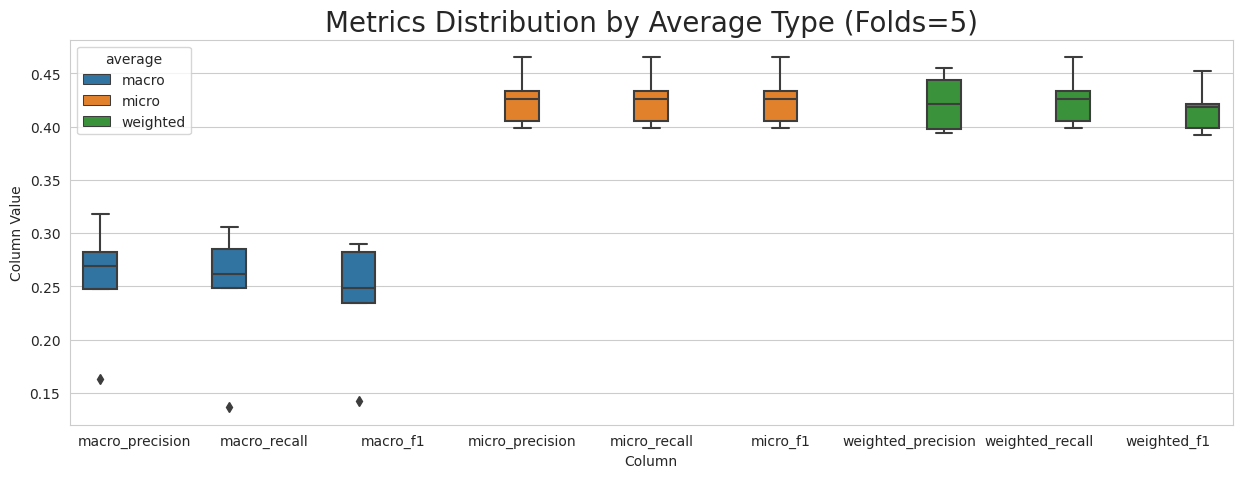

,mean,std
macro_precision,0.255807,0.057953
macro_recall,0.247678,0.065826
macro_f1,0.239616,0.058947
micro_precision,0.425844,0.026166
micro_recall,0.425844,0.026166
micro_f1,0.425844,0.026166
weighted_precision,0.422167,0.027034
weighted_recall,0.425844,0.026166
weighted_f1,0.416336,0.023431


In [8]:
folds_evaluation_df = pd.DataFrame(iterations_tracking)

display(HTML('<h4>Individual Folds Results</h4>'))
display(folds_evaluation_df)

plot_folds_metrics(folds_evaluation_df)

display(HTML('<strong>Summarized Fold Metrics</strong>'))
summarized_validation_metrics_df = (
    folds_evaluation_df
    .drop(columns=['Fold', 'training_size', 'validation_size'])
    .agg(['mean', 'std'])
    .T
)
display(summarized_validation_metrics_df)

### Detailing Largets Fold Results

#### Model Performance per Class

In [9]:
selected_fold = 0
fold_train_df, _ = folds[selected_fold]
fold_y, fold_preds, fold_labels = itemgetter('y', 'preds', 'labels')(resources[selected_fold])

training_support_df = generate_labels_support(fold_train_df).set_index('grupo_estabelecimento')

classification_report_df = generate_classification_report(fold_y, fold_preds, fold_labels)
(
    classification_report_df
    .join(training_support_df)
    .rename(columns={'support': 'validation_support'})
    .astype({'validation_support': int})
    .sort_values(by='training_support', ascending=False)
    .reset_index()
    .rename(columns={'index': 'class'})
    .style
    .applymap(lambda value: 'background-color:#7fb3d5' if value  > .5 else '',
              subset=['f1-score', 'precision', 'recall'])
    .applymap(lambda value: 'background-color:#d2b4de' if value  == 'vestuário' else '',
             subset=['class'])
    .applymap(lambda value: 'font-weight:bold', subset=['class'])
)

,class,precision,recall,f1-score,validation_support,training_support
0,serviço,0.657343,0.717557,0.686131,131,1324
1,restaurante,0.353846,0.338235,0.345865,68,640
2,varejo,0.250000,0.250000,0.250000,56,391
3,supermercados,0.213115,0.260000,0.234234,50,327
4,vestuário,0.181818,0.222222,0.200000,18,179
5,farmácias,0.090909,0.066667,0.076923,15,150
6,posto de gás,0.666667,0.235294,0.347826,17,141
7,compra online,0.304348,0.368421,0.333333,19,123
8,artigos eletro,0.500000,0.300000,0.375000,10,85
9,loja de departamento,0.200000,0.111111,0.142857,9,55


### Confusion Matrix

This section shows the confusion matrix for the top 10 classes (based on frequency).

In [10]:
top_labels_df = (df
 .pipe(clean_data, ['grupo_estabelecimento'])  
 [['grupo_estabelecimento']]
 .assign(records=1)
 .groupby('grupo_estabelecimento')
 .sum()
 .reset_index()
 .sort_values(by='records', ascending=False)
 .head(10)
)

display(HTML(f'<strong>Confusion Matrix for Top 10 Categories based on Model for Fold <code>{selected_fold}</code></strong>'))
confusion_matrix_df = generate_confusion_matrix_report(fold_y, fold_preds, fold_labels)

top_labels = set(top_labels_df['grupo_estabelecimento'].tolist())
top_rows_index = sorted(list(top_labels & set(confusion_matrix_df.index)))
top_columns_index = sorted(list(top_labels & set(confusion_matrix_df.columns.tolist())))

(
    confusion_matrix_df
    .loc[top_rows_index, top_columns_index]
)

,artigos eletro,compra online,farmácias,loja de departamento,posto de gás,restaurante,serviço,supermercados,varejo,vestuário
artigos eletro,3,1,0,0,0,0,4,1,1,0
compra online,0,7,1,1,0,1,1,4,1,3
farmácias,0,0,1,1,0,1,4,5,3,0
loja de departamento,0,0,0,1,0,1,3,1,2,0
posto de gás,0,0,0,0,4,3,2,6,1,1
restaurante,0,1,4,0,1,23,11,15,6,2
serviço,1,3,2,1,0,12,94,6,10,2
supermercados,1,1,0,0,0,9,8,13,14,2
varejo,0,5,2,0,0,10,11,6,14,6
vestuário,0,4,0,0,1,2,4,1,2,4


## Main Model Training

This section creates the final model, using all the `training` set. The final evaluation will be performed in another notebook, to avoid reusing the `test` set.

In [11]:
%%time

clean_df = (
    df
    .drop_duplicates()
    .pipe(clean_data, CATEGORICAL_COLUMNS + [TARGET_COLUMN])
    .pipe(engineer_features)
)

labels = clean_df[TARGET_COLUMN].unique().tolist()

label_encoder, categorical_encoder = generate_encoders(
    clean_df[COLUMNS_SELECTION],
    labels,
    HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
)

X_training, y_training = vectorize_dataset(df,
                                           label_encoder, 
                                           categorical_encoder,
                                           columns_selection=COLUMNS_SELECTION,
                                           categorical_columns=CATEGORICAL_COLUMNS,
                                           binary_columns=BINARY_COLUMNS,
                                           target_column=TARGET_COLUMN,
                                          )

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

extra_artifacts = [
    (confusion_matrix_df, 'validation folds', 'confusion matrix'),
    (summarized_validation_metrics_df, 'validation folds', 'metrics')
]

mlflow_run, model = train_model(
    algorithm_class=LGBMClassifier,
    model_params=model_params,
    X_training=X_training,
    y_training=y_training,
    experiment_run_name=EXPERIMENT_RUN_NAME,
    extra_artifacts=extra_artifacts,
    features_names=COLUMNS_SELECTION,
    labels=labels,
    weights_adjustments=weights_adjustments
)

CPU times: user 1min 7s, sys: 548 ms, total: 1min 7s
Wall time: 9.58 s


### Model Registration and Publication

After creating the model, it is wrapped into an MLFlow class to be used later.

In [12]:
mlflow_model = FinancialClassificationModel(
    categorical_columns=CATEGORICAL_COLUMNS,
    binary_columns=BINARY_COLUMNS,
    numeric_columns=NUMERIC_COLUMNS,
    label_encoder=label_encoder,
    categorical_encoder=categorical_encoder,
    model=model)

Then, the model should be logged into the experiment, registered at the MLflow Registry and published with the `Staging` tag.

In [13]:
log_model(mlflow_model, mlflow_run, configs.mlflow.base_model_name)
model_version = register_model(mlflow_run, configs.mlflow.base_model_name)
publish_model(model_name=configs.mlflow.base_model_name, 
              model_version=model_version, 
              stage="Staging")

2022/08/27 12:47:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: financial_categorization_model, version 37


### Model Artifacts

A set of reports are save on MLFlow to track the experiment. As the final assessment will be performed only at the end, the metrics are computed based on the training data. While it is not a good indicative of generalization capacity of the model, it helps validating that the model is able to learn the patterns from the training set. It is expected that almost all metrics will have a perfect score, especially when using a boosting algorithm.

In [14]:
main_model_artifacts = get_mlflow_artifact_content(mlflow_run.info.run_id, 'main model')

for artifact_name, content in main_model_artifacts.items():
    display(HTML(f'<h4>{artifact_name.capitalize()}</h4>'))
    display(HTML(main_model_artifacts[artifact_name]))

,feature,absolute_importance,relative_importance
16,valor,27914,17.37%
10,limite_disp,22425,13.96%
18,valor_relativo_total,22310,13.89%
17,valor_relativo_disponivel,21426,13.34%
3,dia_mes,17390,10.82%
12,mes,9855,6.13%
4,dia_semana,9109,5.67%
2,cidade_estabelecimento,9081,5.65%
9,idade,7986,4.97%
11,limite_total,7210,4.49%


,metric,value
0,macro_precision,1.0
1,macro_recall,1.0
2,macro_f1,1.0
3,micro_precision,1.0
4,micro_recall,1.0
5,micro_f1,1.0
6,weighted_precision,1.0
7,weighted_recall,1.0
8,weighted_f1,1.0


,class,weight
0,0,31.301587
1,1,187.809524
2,2,1.976942
3,3,15.650794
4,4,6.260317
5,5,1.322602
6,6,2.276479
7,7,11.738095
8,8,8.943311
9,9,37.561905


,precision,recall,f1-score,support
serviço,1.0,1.0,1.0,6.0
farmácias,1.0,1.0,1.0,1.0
compra online,1.0,1.0,1.0,95.0
artigos eletro,1.0,1.0,1.0,12.0
varejo,1.0,1.0,1.0,30.0
loja de departamento,1.0,1.0,1.0,142.0
vestuário,1.0,1.0,1.0,165.0
móveis e decoração,1.0,1.0,1.0,16.0
hospitais e clínicas,1.0,1.0,1.0,21.0
sem ramo,1.0,1.0,1.0,5.0


## Concluding Remarks
 - Effectiveness:
     - The F1 performance on the `validation folds` are low (about 45% of F1, based on micro average). The main reason might be related to the unbalance and low frequency of some categories and dataset unbalance.
     - The most recent fold has the second worst performance. That is curious because it has the highest ammount of training data.
     - The best performance was on the last fold, with the least ammount of data. That might be an indicative that it is important to keep only recent data with respect to the prediction data. It can be achieved by restrincting the training window of data or reducing the weights of old data.
     - Only two classes (`serviço` and `posto de gás`) presented F1 score higher than `0.5` on the largest fold.
 - Features:
     - Features based on `valor` and `limite` are the most important for the algorithm.
     - From the new feature created, `dia_mes` and `mes` were the most relevant. That is interesting for the final assessment because the dataset contains only 1 year of data. The test set will not have data with known months at the training set.
     - There are 7 features with less than 1% of relative importance. 
 
 - Overwall:
     - As there is a limited number of records related to the less frequent categories, an alternative approach would be grouping all of them into a `others` group. 
 
 
Some alternative approaches could be experimented:
 - Perform hyperparameters tuning using [Optuna](https://optuna.org/).
 - Make older data less relevant by decreasing the weights of each record based on time.
 - Use [alternative encoders](https://contrib.scikit-learn.org/category_encoders) for high cardinality categories. `Catboost` and `LeaveOneOut` are some of the notable candidates.
 - Apply alternative classification algorithms to improve results (e.g., Neural Networks and [CatBoost](https://catboost.ai/)).
 - Eliminate noisy or conflicting data by using techniques such as [Tomek Links](https://imbalanced-learn.org/stable/under_sampling.html#tomek-links).
 - Perform adversarial validation to check drift between `training` and `assessment` datasets.
 - Use SHAP to compute feature importance in a more reliable way.